In [22]:
%%capture
pip install category-encoders

In [23]:
%%capture
pip install boruta


In [24]:
%%capture
pip install scikit-optimize


In [25]:
#Basic libraries
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

#Sampling methods
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

#feature engineering
import datetime as dt
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler

#Feature Selection
from boruta import BorutaPy

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

#Hyperparameter tuning
from skopt import gp_minimize

#Model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
import scipy.stats as stats
from scipy.stats import skew

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
dataset = "/content/drive/MyDrive/fraud predict/Datasets/fraudTrain.csv"

df = pd.read_csv(dataset)
pd.options.display.float_format = '{:,.2f}'.format
display(df.head(2))

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

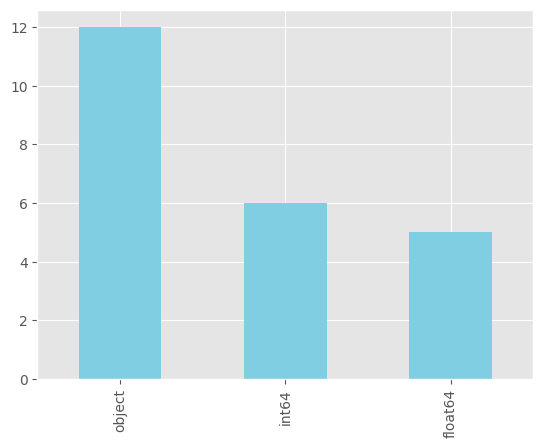

In [29]:
df.dtypes.value_counts().plot(kind='bar', color='#80CEE1');

In [30]:
# null cells verification
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

We don't have missing values in our dataset.

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,"1,296,675.00","648,337.00","374,317.97",0.00,"324,168.50","648,337.00","972,505.50","1,296,674.00"
cc_num,"1,296,675.00","417,192,042,079,726,656.00","1,308,806,447,000,240,384.00","60,416,207,185.00","180,042,946,491,150.00","3,521,417,320,836,166.00","4,642,255,475,285,942.00","4,992,346,398,065,154,048.00"
amt,"1,296,675.00",70.35,160.32,1.00,9.65,47.52,83.14,"28,948.90"
zip,"1,296,675.00","48,800.67","26,893.22","1,257.00","26,237.00","48,174.00","72,042.00","99,783.00"
lat,"1,296,675.00",38.54,5.08,20.03,34.62,39.35,41.94,66.69
long,"1,296,675.00",-90.23,13.76,-165.67,-96.80,-87.48,-80.16,-67.95
city_pop,"1,296,675.00","88,824.44","301,956.36",23.00,743.00,"2,456.00","20,328.00","2,906,700.00"
unix_time,"1,296,675.00","1,349,243,636.73","12,841,278.42","1,325,376,018.00","1,338,750,742.50","1,349,249,747.00","1,359,385,375.50","1,371,816,817.00"
merch_lat,"1,296,675.00",38.54,5.11,19.03,34.73,39.37,41.96,67.51
merch_long,"1,296,675.00",-90.23,13.77,-166.67,-96.90,-87.44,-80.24,-66.95


In [32]:
df["amt"].describe()

count   1,296,675.00
mean           70.35
std           160.32
min             1.00
25%             9.65
50%            47.52
75%            83.14
max        28,948.90
Name: amt, dtype: float64

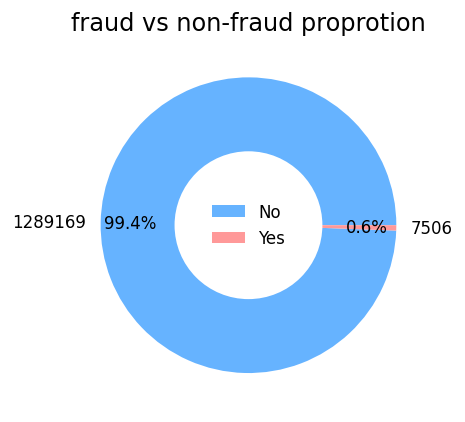

In [33]:
# checking fraud vs non-fraud proprotion
donut = df["is_fraud"].value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)
colors = ['#66b3ff', '#ff9999']

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["is_fraud"],
        labels=donut["is_fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode,
        colors=colors)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("fraud vs non-fraud proprotion")
plt.legend(labels, loc="center", frameon=False)
plt.show();

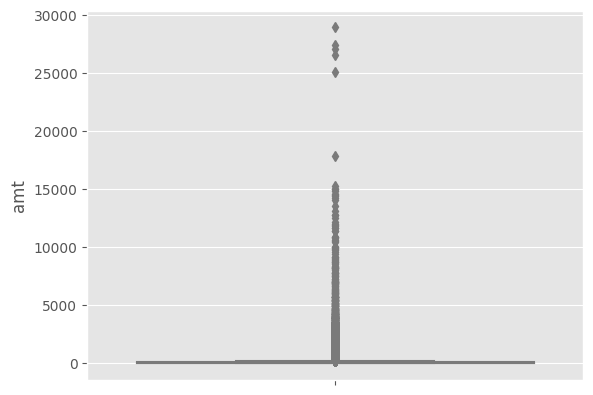

In [34]:
# checking amount distribution
#sns.kdeplot(df["amt"], fill=True);
sns.boxplot(data=df, y="amt", orient="v", palette = sns.color_palette("pastel"));

We have some very high values ​​that are making it difficult to visualize the graph, so we can smooth this data according to the concentration of values ​​in the rest of our dataset.

In [35]:
p95 = df["amt"].quantile(0.95)
p96 = df["amt"].quantile(0.96)
p97 = df["amt"].quantile(0.97)
p98 = df["amt"].quantile(0.98)
p99 = df["amt"].quantile(0.99)
print("\n","p95:", p95,
      "\n","p96:", p96,
      "\n","p97:", p97,
      "\n","p98:", p98,
      "\n","p99:", p99)


 p95: 196.31 
 p96: 214.46 
 p97: 248.06780000000026 
 p98: 337.98 
 p99: 545.9926000000002


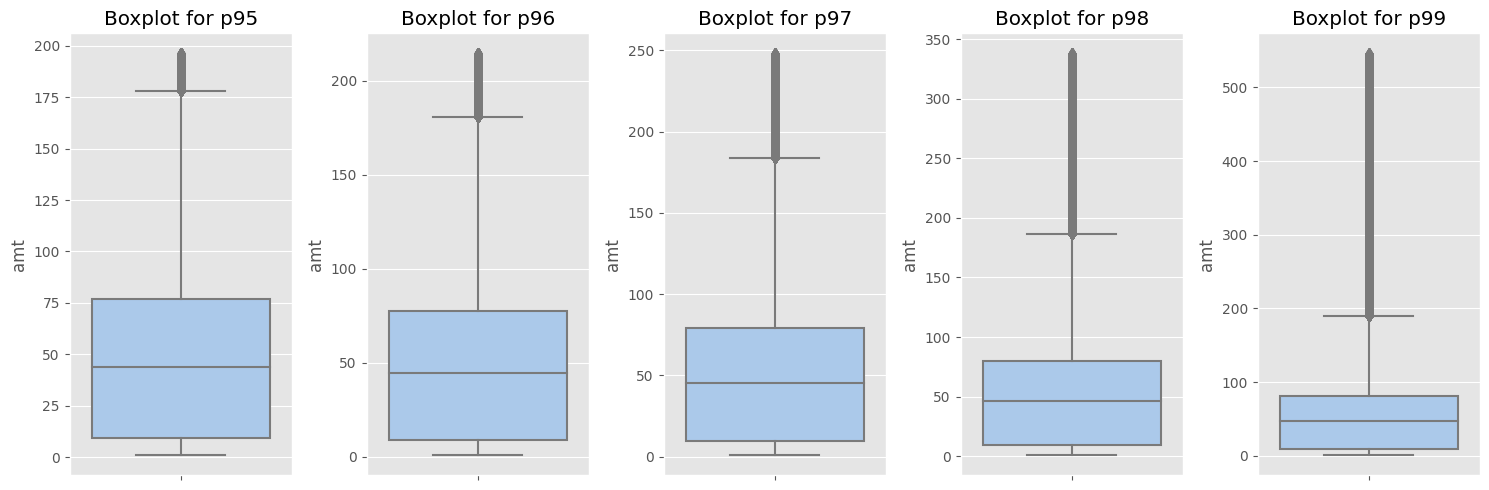

In [36]:
p_list = [95, 96, 97, 98, 99]

# Crie uma figura com várias subtramas
fig, axes = plt.subplots(1, len(p_list), figsize=(15, 5))

# Loop for para criar gráficos de boxplot para cada percentil
for i, p in enumerate(p_list):
    # Calcule o valor do percentil
    percentile_value = df["amt"].quantile(p / 100)

    # Filtre os dados com base no percentil atual
    filtered_data = df[df["amt"] <= percentile_value]

    # Crie o gráfico de boxplot na subtrama correspondente
    sns.boxplot(data=filtered_data, y="amt", orient="v", palette=sns.color_palette("pastel"), ax=axes[i])
    axes[i].set_title(f'Boxplot for p{p}')

# Ajuste o layout para evitar sobreposições
plt.tight_layout()
plt.show()

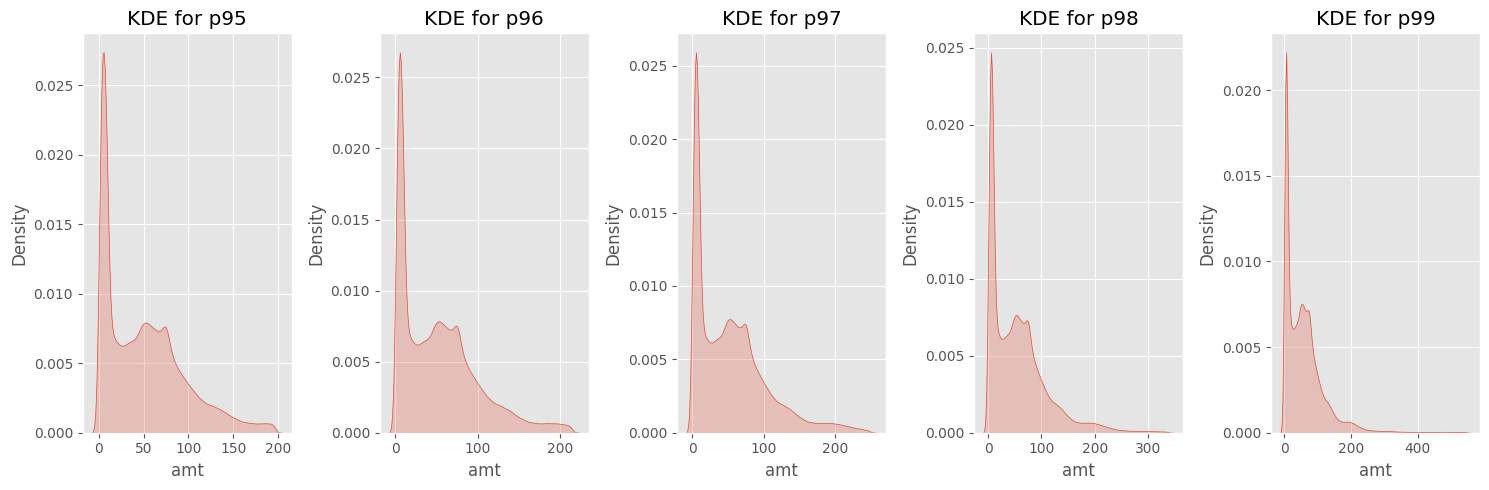

In [37]:
# Crie uma figura com várias subtramas
fig, axes = plt.subplots(1, len(p_list), figsize=(15, 5))

# Loop for para criar gráficos de boxplot para cada percentil
for i, p in enumerate(p_list):
    # Calcule o valor do percentil
    percentile_value = df["amt"].quantile(p / 100)

    # Filtre os dados com base no percentil atual
    filtered_data = df[df["amt"] <= percentile_value]

    # Crie o gráfico de boxplot na subtrama correspondente
    sns.kdeplot(x="amt", data=filtered_data, fill=True, ax=axes[i])
    axes[i].set_title(f'KDE for p{p}')

# Ajuste o layout para evitar sobreposições
plt.tight_layout()
plt.show()

So we can see that the most of transactions are beteen 0 - 100 USD. And it's possible to have this analisys using the p99 percentile. However we also have some transactions out of this amount range that we will have to consider in our model. Let's check the fraud event "describe()"

In [38]:
fraudulent_data = df[df['is_fraud'] == 1]
fraudulent_data['amt'].describe()

count   7,506.00
mean      531.32
std       390.56
min         1.06
25%       245.66
50%       396.50
75%       900.88
max     1,376.04
Name: amt, dtype: float64

Here we can see, that we have some 'amt' data from our event (fraud) bigger than our 'p99', so to avoid losing these on our analysis we choose to cut our df in our max 'amt' fraud that is around 1377 usd. However we will keep the data to use in our model.

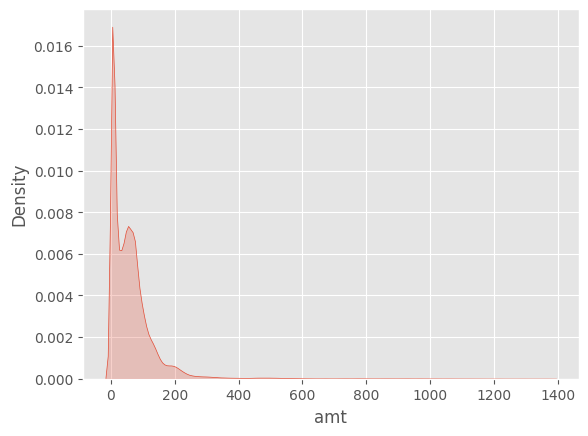

In [39]:
filtered_data = df[df["amt"] <= 1377]
sns.kdeplot(x="amt", data=filtered_data, fill=True)
plt.show()


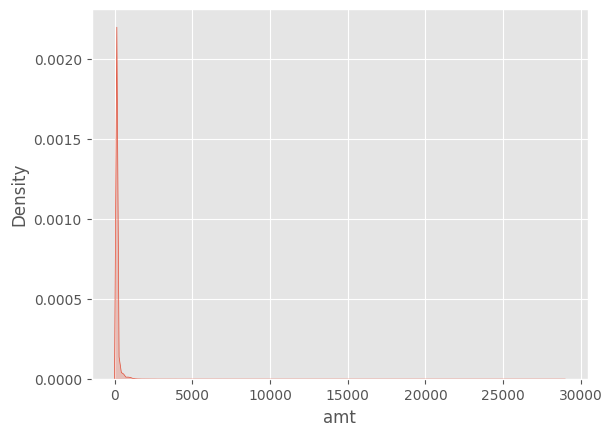

In [40]:
sns.kdeplot(x="amt", data=df, fill=True)
plt.show()

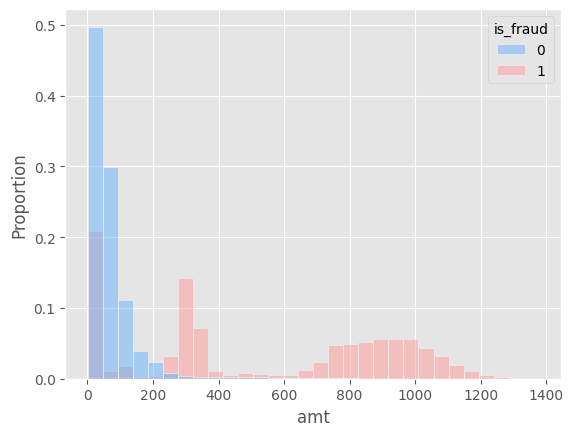

In [41]:
palette = ['#66b3ff', '#ff9999']
sns.histplot(x="amt", hue="is_fraud", bins=30,
             stat="proportion", data=df[df["amt"] <= 1377],
             common_norm=False,
             palette=palette);

As we can see above, we have a different concentration of values ​​for transactions with a high probability of fraud compared to those with a high probability of non-fraud.
So lets take a look and compare the other metrics of our dataset based on fraud vs nonfraud distribution.

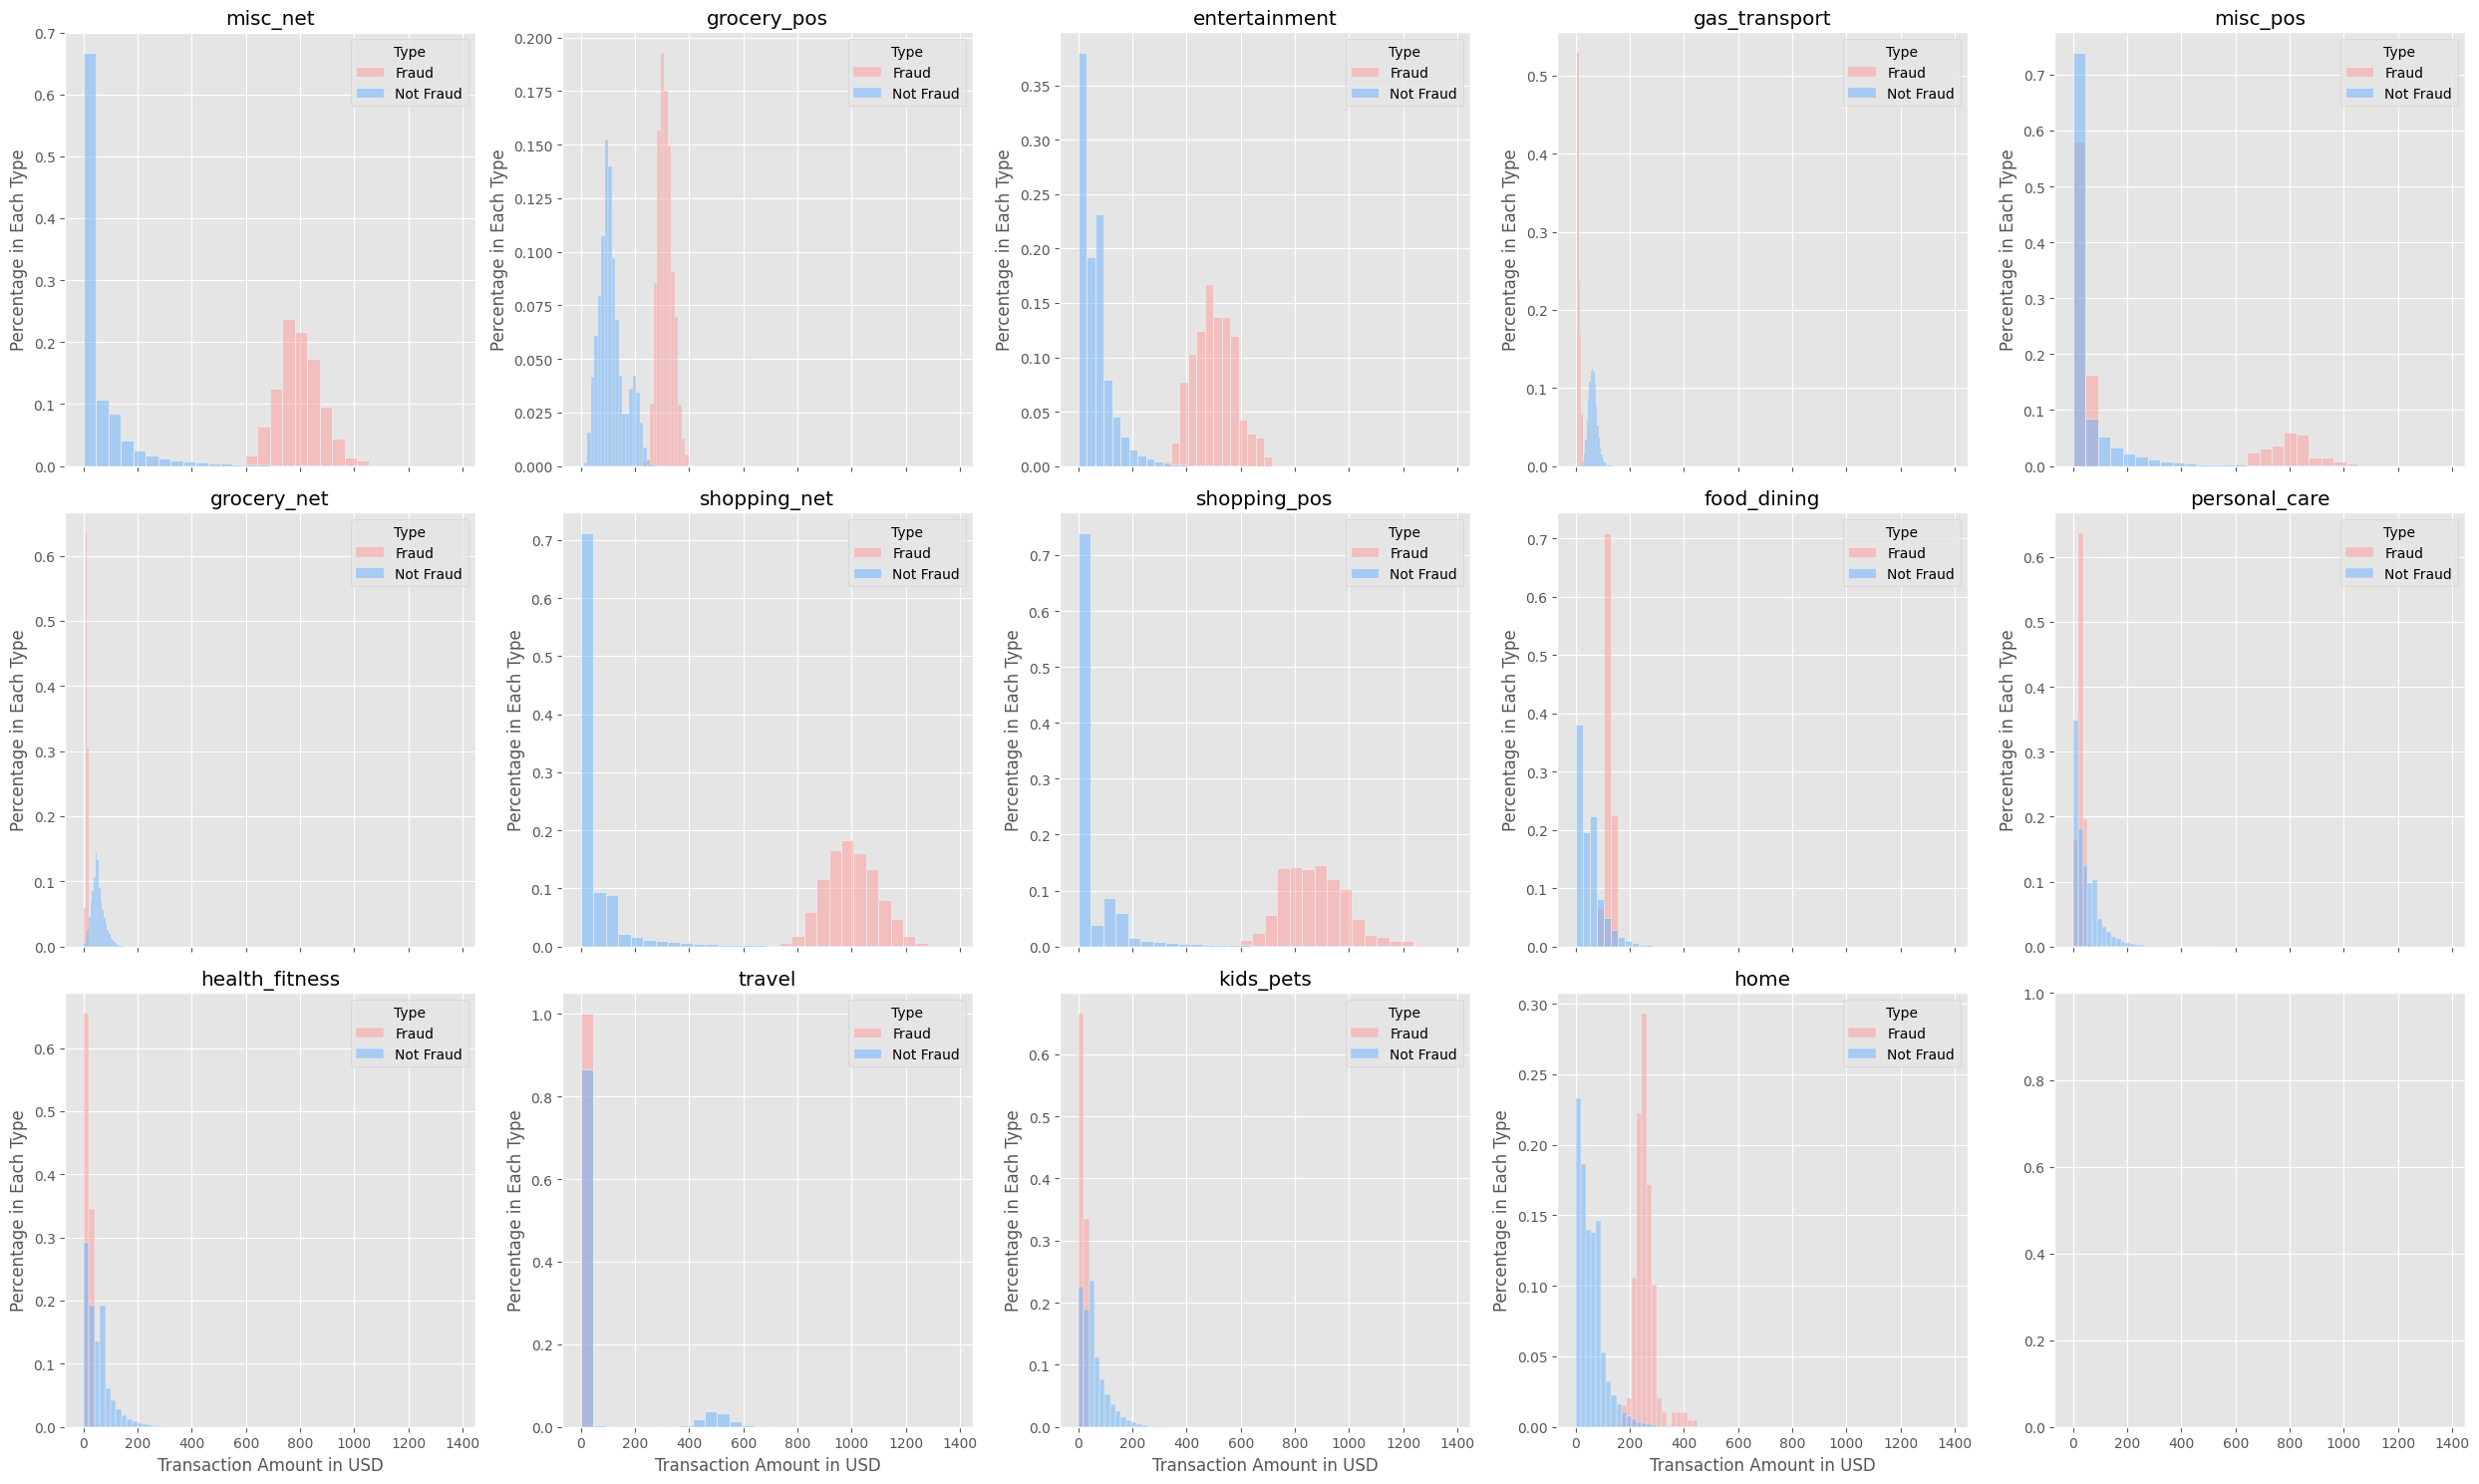

In [42]:
categories = df['category'].unique()

num_plots = len(categories)
num_rows = math.isqrt(num_plots)
num_cols = math.ceil(num_plots / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(
    5*num_cols, 5*num_rows), sharex=True)

palette = ['#66b3ff', '#ff9999']

for i, category in enumerate(categories):

    row = i // num_cols
    col = i % num_cols

    data_category = df[df['category'] == category]

    if num_rows == 1 and num_cols == 1:
        ax = axes
    elif num_rows == 1 or num_cols == 1:
        ax = axes[i]
    else:
        ax = axes[row, col]

    sns.histplot(x='amt', data=data_category[data_category['amt'] <= 1377],
                 hue='is_fraud', stat='probability',
                 common_norm=False, palette=palette,bins=30, ax=ax)

    ax.set_ylabel('Percentage in Each Type')
    ax.set_xlabel('Transaction Amount in USD')
    ax.set_title(f'{category}')
    ax.legend(title='Type',  labels=['Fraud', 'Not Fraud'])

plt.tight_layout()

plt.show();

It can be observed that fraudulent transactions have a higher value than non-fraudulent transactions in most cases as a common behavior.

In [43]:
non_fraud_total_rows = len(df[df['is_fraud'] == 0])
fraud_total_rows = len(df[df['is_fraud'] == 1])

# non_fraud
non_fraud = df[df['is_fraud'] == 0]['category'].value_counts().to_frame().reset_index()
non_fraud.columns = ['category', 'non_fraud_transactions']
non_fraud['non_fraud_by_category%'] = (non_fraud['non_fraud_transactions'] / non_fraud_total_rows) * 100

# fraud
fraud = df[df['is_fraud'] == 1]['category'].value_counts().to_frame().reset_index()
fraud.columns = ['category', 'fraud_transactions']
fraud['fraud_by_category%'] = (fraud['fraud_transactions'] / fraud_total_rows) * 100

# merging two dataframes and calculating "fraud level"
non_fraud_vs_fraud = non_fraud.merge(fraud, on='category')
non_fraud_vs_fraud['fraud_probability%'] = non_fraud_vs_fraud['fraud_transactions'] / (non_fraud_vs_fraud['fraud_transactions'] + non_fraud_vs_fraud['non_fraud_transactions']) * 100


display(non_fraud_vs_fraud)



,category,non_fraud_transactions,non_fraud_by_category%,fraud_transactions,fraud_by_category%,fraud_probability%
0,gas_transport,131041,10.16,618,8.23,0.47
1,home,122917,9.53,198,2.64,0.16
2,grocery_pos,121895,9.46,1743,23.22,1.41
3,shopping_pos,115829,8.98,843,11.23,0.72
4,kids_pets,112796,8.75,239,3.18,0.21
5,shopping_net,95830,7.43,1713,22.82,1.76
6,entertainment,93781,7.27,233,3.10,0.25
7,food_dining,91310,7.08,151,2.01,0.17
8,personal_care,90538,7.02,220,2.93,0.24
9,health_fitness,85746,6.65,133,1.77,0.15


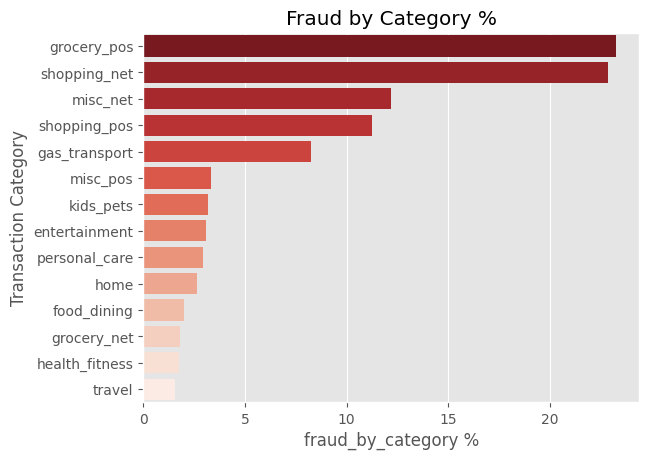

In [44]:
palette = sns.color_palette("Reds_r", n_colors=len(non_fraud_vs_fraud))

ax = sns.barplot(y='category', x='fraud_by_category%',
                 data=non_fraud_vs_fraud.sort_values('fraud_by_category%', ascending=False), palette=palette)
ax.set_xlabel('fraud_by_category %')
ax.set_ylabel('Transaction Category')
plt.title('Fraud by Category %');

This chart shows that “grocery_pos” is the category with the most fraudulent transactions (23.22% of all fraudulent transactions) and “travel” is the category with the least fraudulent transactions at 1.55%. But if we consider the transaction volume of which category we can see which category is more likely to have fraudulent transactions.

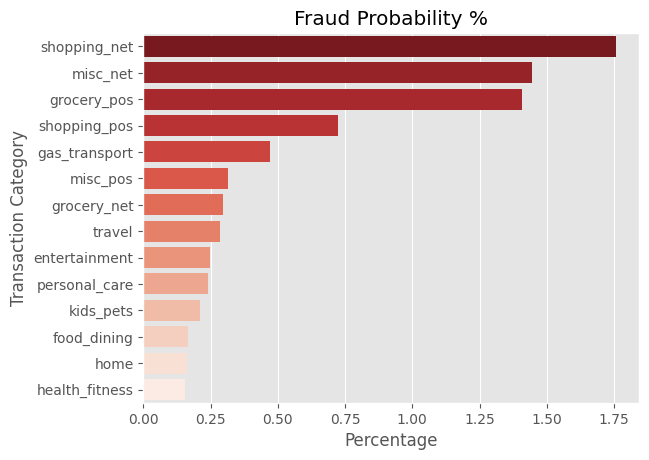

In [45]:
palette = sns.color_palette("Reds_r", n_colors=len(non_fraud_vs_fraud))

ax = sns.barplot(y='category', x='fraud_probability%',
                 data=non_fraud_vs_fraud.sort_values('fraud_probability%', ascending=False), palette=palette)
ax.set_xlabel('Percentage')
ax.set_ylabel('Transaction Category')
plt.title('Fraud Probability %');

Therefore “shopping_net” is the category with the highest probability of fraudulent transactions with a 1.76% chance and “health_fitness” with the lowest probability of fraud with a 0.15% chance.

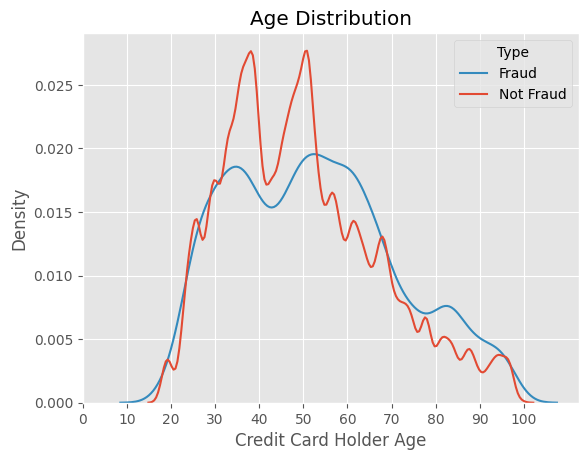

In [46]:
df['age'] = dt.date.today().year-pd.to_datetime(df['dob']).dt.year
ax = sns.kdeplot(x='age', data=df, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0, 110, 10))
plt.title('Age Distribution')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud']);

We can observe slightly similar behavior in both curves, but we also have a peak around 35 - 40 years and 50 - 55 years for non-fraudulent behavior.

Let's see if the time of transactions can show any influence on the fraud rate.

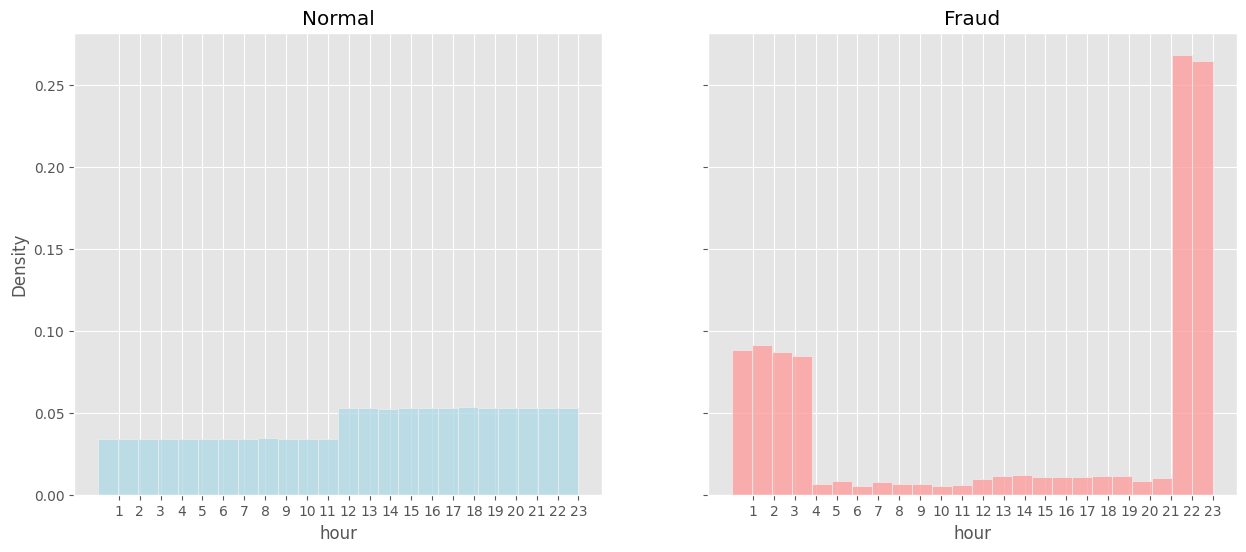

In [47]:
df['hour'] = pd.to_datetime(df['trans_date_trans_time']).dt.hour
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='hour', data=df[df["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1, color="lightblue")
ax2 = sns.histplot(x='hour', data=df[df["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="#ff9999")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 24))
ax2.set_xticks(np.arange(1, 24));

We can see a peak in fraudulent transactions between 9 - 11 pm and during the early hours of the morning a higher rate than the rest of the day.

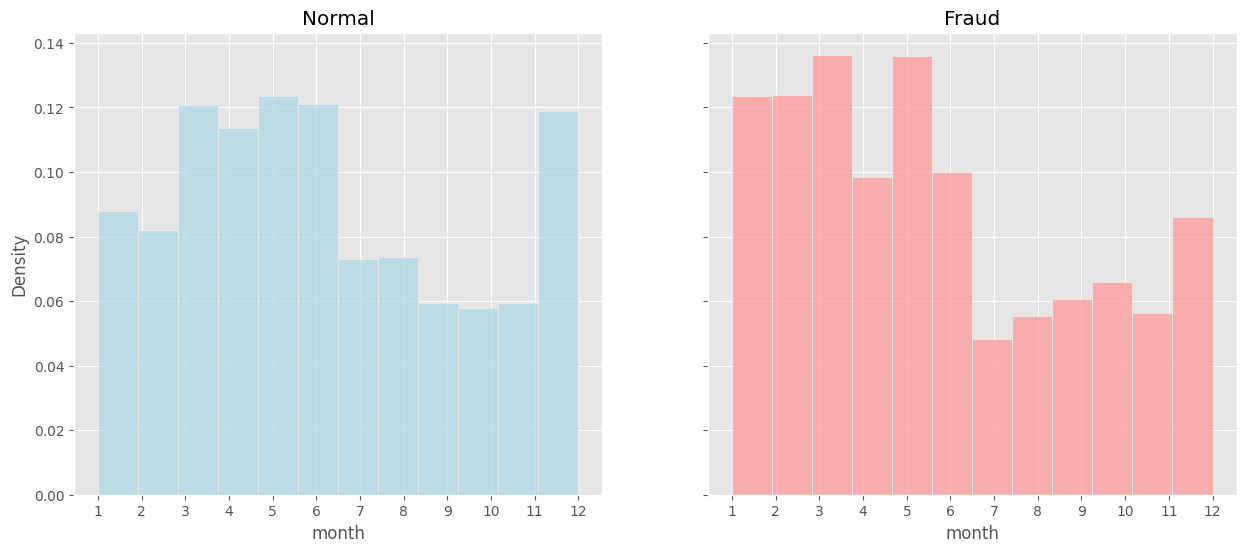

In [48]:
df['month'] = pd.to_datetime(df['trans_date_trans_time']).dt.month
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='month', data=df[df["is_fraud"] == 0],
                   stat="density", bins=12, ax=ax1, color="lightblue")
ax2 = sns.histplot(x='month', data=df[df["is_fraud"] == 1],
                   stat="density", bins=12, ax=ax2, color="#ff9999")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 13))
ax2.set_xticks(np.arange(1, 13));

In [49]:
# dropping columns with duplicated or irrelevant information.

df_train = df.drop(['Unnamed: 0'], axis=1)
display(df_train.head(2))

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,hour,month
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0,35,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0,45,0,1


To facilitate the visual analysis of the "amt" variable, we can create a logarithmic scale in this way, approximating the most discrepant values.

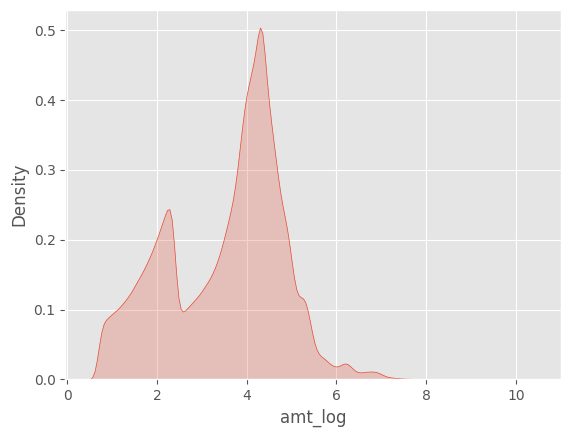

In [50]:
df_train["amt_log"] = np.log1p(df_train["amt"])
sns.kdeplot(df_train["amt_log"], fill=True);

Checking the normality of the "amt" feature compared to its transformation "amt_log".

In [51]:
def check_normality(feature):
    plt.figure(figsize=(8, 8))
    ax1 = plt.subplot(1, 1, 1)
    stats.probplot(df_train[feature], dist=stats.norm, plot=ax1)
    ax1.set_title(f'{feature} Q-Q plot', fontsize=20)
    sns.despine()

    mean = df_train[feature].mean()
    std = df_train[feature].std()
    skew = df_train[feature].skew()
    print(f'{feature} : mean: {mean:.2f}, std: {std:.2f}, skew: {skew:.2f}')

amt : mean: 70.35, std: 160.32, skew: 42.28


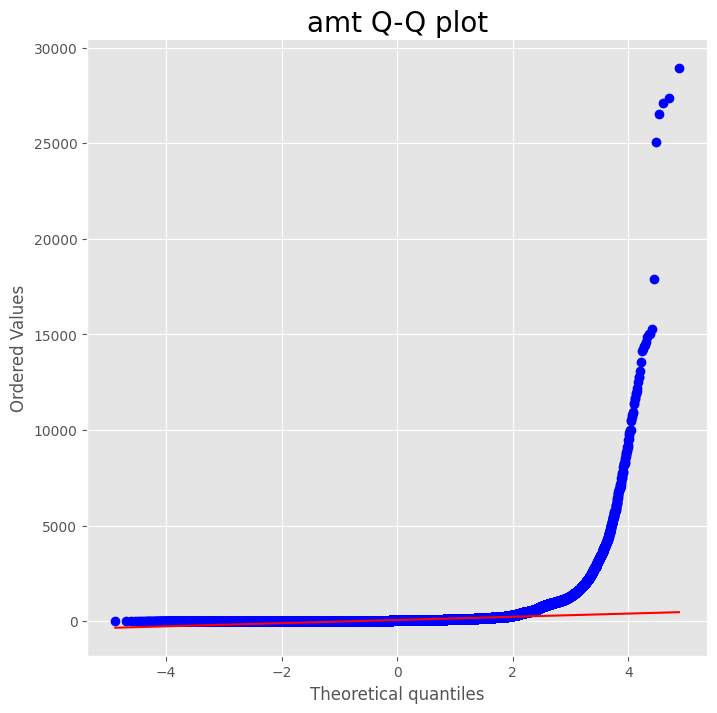

In [52]:
check_normality("amt")

amt_log : mean: 3.53, std: 1.29, skew: -0.30


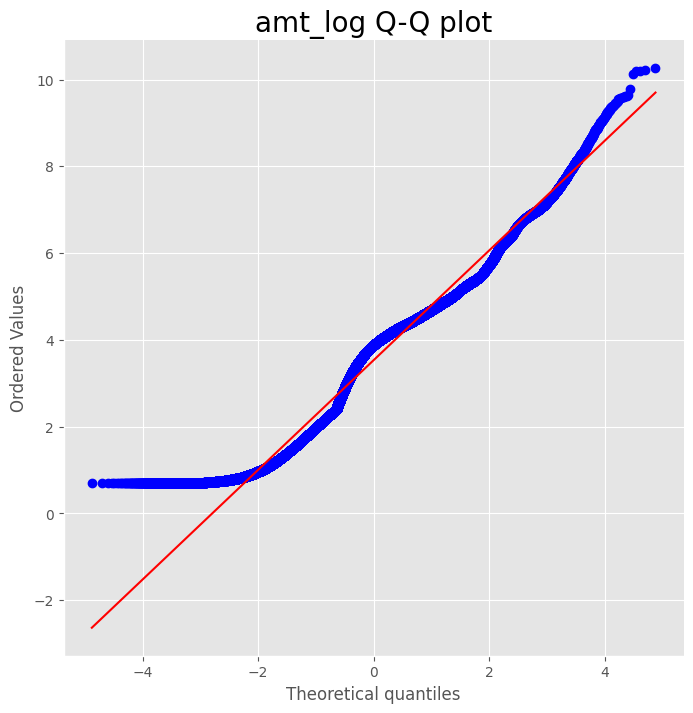

In [53]:
check_normality("amt_log")

We can observe a great improvement in symmetry after the creation of the logarithmic scale "amt_log"

Now let's categorize some variables from our dataset to use in our model. We are going to apply WOE to transform object colunms to float.

In [54]:
def apply_woe(df_train, columns, target_col):
    woe = ce.WOEEncoder()

    for col in columns:
        X = df_train[col]
        y = df_train[target_col]

        new_col_name = f"{col}_WOE"
        df_train[new_col_name] = woe.fit_transform(X, y)

    return df_train


columns_to_encode = ["category", "state", "city", "job"]
target_column = "is_fraud"

df_train = apply_woe(df_train, columns_to_encode, target_column)

In [55]:
display(df_train.head(2))

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,hour,month,amt_log,category_WOE,state_WOE,city_WOE,job_WOE
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0,35,0,1,1.79,0.92,-0.16,-2.47,-1.08
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0,45,0,1,4.68,0.90,-0.12,-3.03,-0.90


For the sex variable we will apply dummies.

In [56]:
gender_mapping = {"F": 0, "M": 1}

df_train["gender_binary"] = df_train["gender"].map(gender_mapping)

We can encode the cc_num (credit card number) variable as well, by counting their frequencies in the database and them dividing them into categories, so we can classify the cards that are used a lot, and the ones that are not used often in the database.

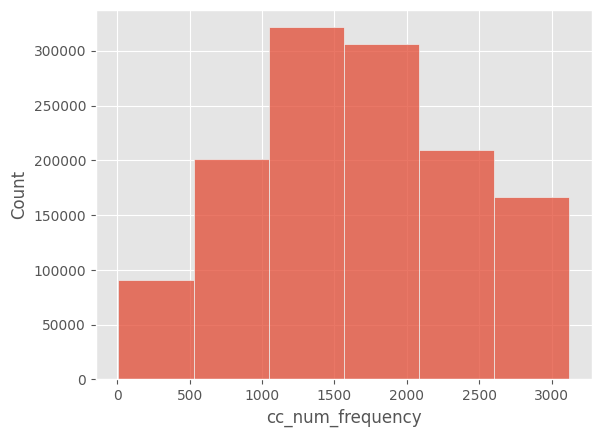

In [57]:
freq_enc = (df_train.groupby("cc_num").size())
freq_enc.sort_values(ascending=True)
df_train["cc_num_frequency"] = df_train["cc_num"].apply(lambda x: freq_enc[x])


sns.histplot(df_train["cc_num_frequency"], bins=6);

In [58]:
intervals = [600, 1200, 1800, 2400, 3000, 3600]


def classify_frequency(freq):
    for i, c in enumerate(intervals):
        if freq <= c:
            return i


df_train["cc_num_frequency_classification"] = df_train["cc_num_frequency"].apply(
    classify_frequency)

Checking non_fraud vs fraud distribution.

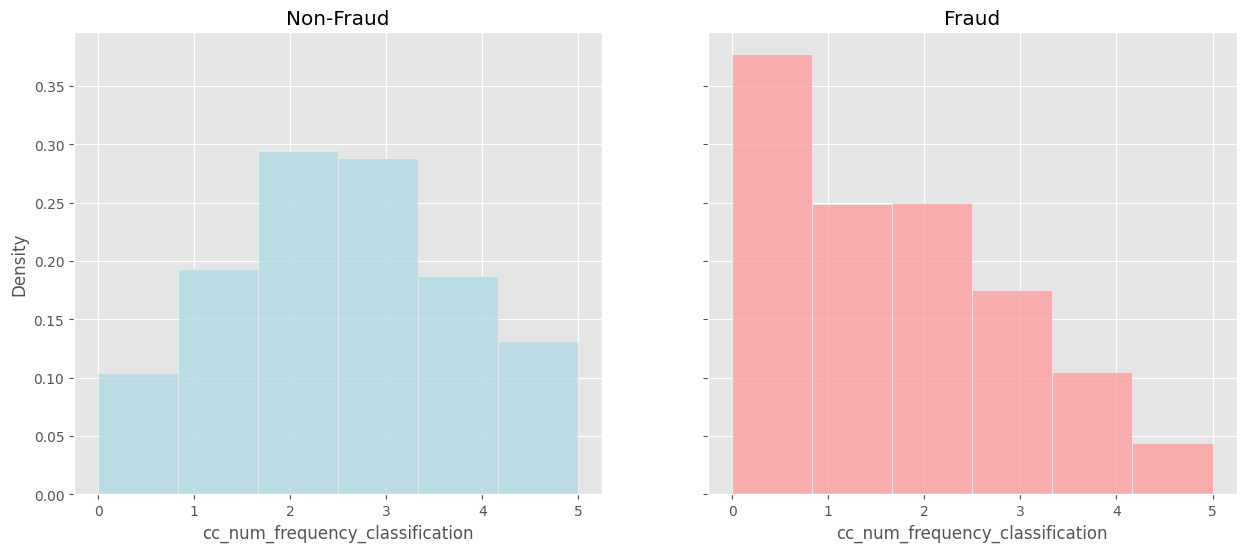

In [59]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='cc_num_frequency_classification', data=df_train[df_train["is_fraud"] == 0],
                   stat="density", bins=6, ax=ax1, color="lightblue")
ax2 = sns.histplot(x='cc_num_frequency_classification', data=df_train[df_train["is_fraud"] == 1],
                   stat="density", bins=6, ax=ax2, color="#ff9999")
ax1.set_title("Non-Fraud")
ax2.set_title("Fraud");

When comparing the graphs above, we can see a common behavior in the fraud rate for recently created and little-used credit cards.

# Undersampling

We chose an undersampling method to improve the proportion of event vs non-event in our dataset and thus make our model able to learn more accurately. I will user RandomUnderSampler.

In [60]:
X = df_train.drop(columns=["is_fraud"])
y = df_train["is_fraud"]

rus = RandomUnderSampler(sampling_strategy=0.1, random_state=23)
X_undersampled, y_undersampled = rus.fit_resample(X, y)

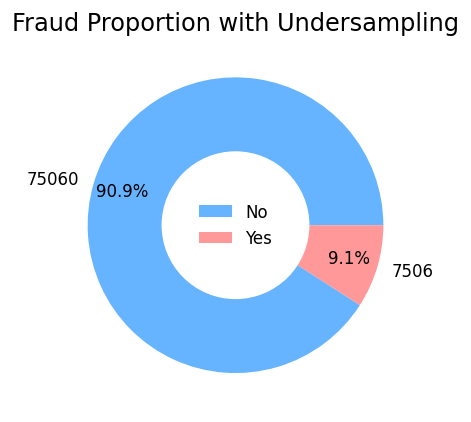

In [61]:
# Checking the new proportion

donut = y_undersampled.value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)
colors = ['#66b3ff', '#ff9999']

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["is_fraud"],
        labels=donut["is_fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode,
        colors=colors)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud Proportion with Undersampling")
plt.legend(labels, loc="center", frameon=False)
plt.show();

# Feature Importance

Now we are going to generate two random vectors to help us compare the feature importances (If a feature has less importance than a random vector, we can suspect that the feature is not good for the model).

In [62]:
X_undersampled["random_feat_1"] = np.random.randint(
    0, 100, size=len(X_undersampled))
X_undersampled["random_feat_2"] = np.random.randint(
    0, 500, size=len(X_undersampled))

In [63]:
X_train = X_undersampled.drop(columns=["merchant", "first", "last", "street",
                                       "unix_time", "trans_num","trans_date_trans_time",
                                       "city", "state", "category", "gender", "dob",
                                       "job", "cc_num", "amt"])

y_train = y_undersampled

In [64]:
X_train.head(2)

,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,month,amt_log,category_WOE,state_WOE,city_WOE,job_WOE,gender_binary,cc_num_frequency,cc_num_frequency_classification,random_feat_1,random_feat_2
0,77566,29.04,-95.44,28739,29.24,-95.43,24,5,3,3.89,-0.21,-0.14,0.14,0.35,1,2556,4,28,65
1,12460,42.41,-74.15,277,41.56,-74.09,52,7,9,4.65,0.90,0.14,0.20,0.70,1,1548,2,76,26


In [65]:
rf = RandomForestClassifier(random_state=23, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=999)
result_boruta = feat_selector.fit(X_train.values, y_train)
accept = X_train.columns[feat_selector.support_].to_list()
irresolution = X_train.columns[feat_selector.support_weak_].to_list()

print("Features selected:")
list(accept)

Features selected:


['zip',
 'lat',
 'long',
 'city_pop',
 'merch_lat',
 'merch_long',
 'age',
 'hour',
 'month',
 'amt_log',
 'category_WOE',
 'state_WOE',
 'city_WOE',
 'job_WOE',
 'gender_binary',
 'cc_num_frequency',
 'cc_num_frequency_classification']

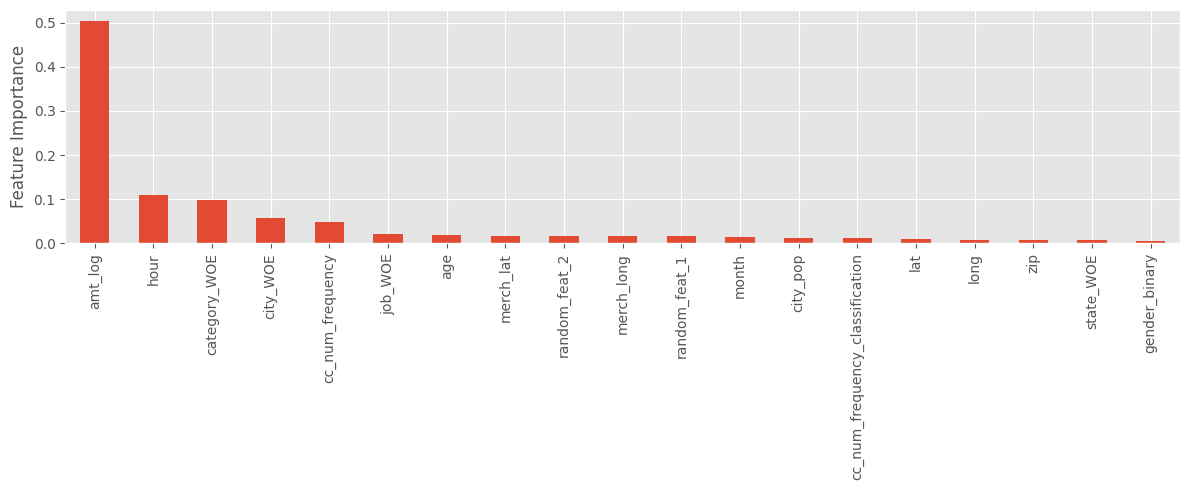

In [66]:
# Checking the feature importance with Random Forest.
rf = RandomForestClassifier(random_state=23)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(12, 5))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_ylabel("Feature Importance")
fig.tight_layout();

Now we can eliminate columns with less relevance than the random vectors we created to test feature importances.

In [67]:
X_train.drop(columns=["random_feat_2", "merch_long", "random_feat_1", "month", "cc_num_frequency_classification",
                      "city_pop", "lat", "zip", "long", "state_WOE", "gender_binary"], inplace=True)


In [68]:

X_train.head(2)

,merch_lat,age,hour,amt_log,category_WOE,city_WOE,job_WOE,cc_num_frequency
0,29.24,24,5,3.89,-0.21,0.14,0.35,2556
1,41.56,52,7,4.65,0.90,0.20,0.70,1548


Now we can finally use our train dataset on our models, But before doing it lets prepare our test dataset by applying the same alterations we made ate the train dataset.

# Preparing test data

In [69]:
val_dataset = "/content/drive/MyDrive/fraud predict/Datasets/fraudTest.csv"

df_val = pd.read_csv(val_dataset)

df_val['age'] = dt.date.today().year-pd.to_datetime(df_val['dob']).dt.year
df_val['hour'] = pd.to_datetime(df_val['trans_date_trans_time']).dt.hour
df_val['month'] = pd.to_datetime(df_val['trans_date_trans_time']).dt.month

df_val.drop(columns=["merchant", "first", "last", "street",
                   "unix_time", "trans_num"], inplace=True)

df_val["amt_log"] = np.log1p(df_val["amt"])

df_val = apply_woe(df_val, columns_to_encode, target_column)

df_val["gender_binary"] = df_val["gender"].map(gender_mapping)

freq_enc_val = (df_val.groupby("cc_num").size())
freq_enc_val.sort_values(ascending=True)
df_val["cc_num_frequency"] = df_val["cc_num"].apply(lambda x: freq_enc_val[x])
df_val["cc_num_frequency_classification"] = df_val["cc_num_frequency"].apply(
    classify_frequency)

X_val = df_val.drop(columns=["trans_date_trans_time",
                            "city", "state", "category", "gender", "dob", "job", "cc_num", "amt", "is_fraud"])

y_val = df_val["is_fraud"]

X_val.drop(columns=["Unnamed: 0", "merch_long", "month", "cc_num_frequency_classification",
                    "city_pop", "lat", "zip", "long", "state_WOE", "gender_binary"], inplace=True)

In [70]:
display(X_train.head(1))
display(X_val.head(1))

,merch_lat,age,hour,amt_log,category_WOE,city_WOE,job_WOE,cc_num_frequency
0,29.24,24,5,3.89,-0.21,0.14,0.35,2556


,merch_lat,age,hour,amt_log,category_WOE,city_WOE,job_WOE,cc_num_frequency
0,33.99,55,12,1.35,-0.76,-0.91,-2.24,640


#Preparing validation data

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2)

#Training the model

In [72]:
def evaluate_model(target, predicted, y_score, normalize_matrix= None):
    accuracy = metrics.accuracy_score(target, predicted)
    precision = metrics.precision_score(target, predicted)
    recall = metrics.recall_score(target, predicted)
    f1 = f1_score(target, predicted)
    auc = metrics.roc_auc_score(target, y_score)

    confusion_matrix = metrics.confusion_matrix(
        target, predicted, normalize=normalize_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    fpr, tpr, threshold = roc_curve(target, y_score)
    plt.plot(fpr, tpr, label="Model", c="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", c="yellow")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    print("AUC:", auc)
    return None

Now let's try some diferent models and so we can analyse wich one is better.

In [73]:
rf = RandomForestClassifier(random_state=23)
knn = KNeighborsClassifier()
gboost = GradientBoostingClassifier(random_state=23)
lgbm = LGBMClassifier(random_state=23)

In [93]:
#random forest

rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_score_train = rf.predict_proba(X_train)[:,1]

y_pred_val = rf.predict(X_val)
y_score_val = rf.predict_proba(X_val)[:,1]

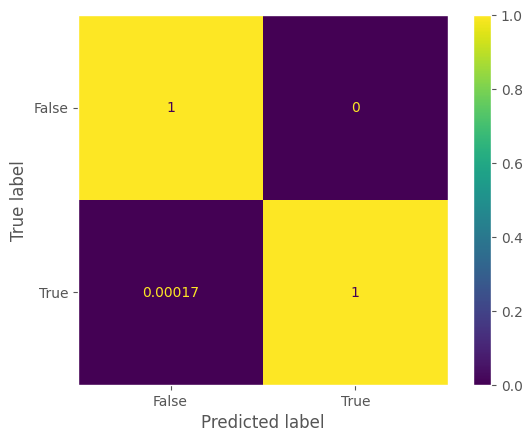

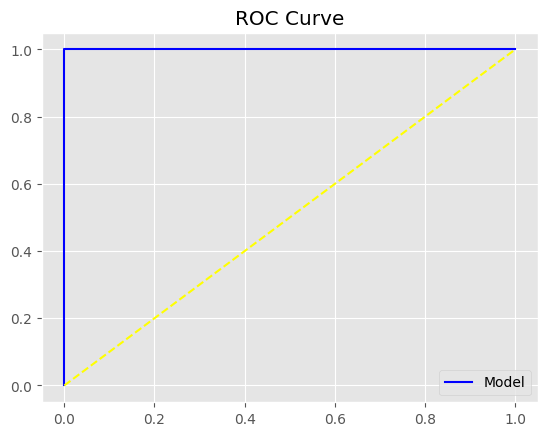

Accuracy 1.0
Precision: 1.0
Recall: 1.0
F1 Score 1.0
AUC: 1.0


In [94]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train, normalize_matrix="true")

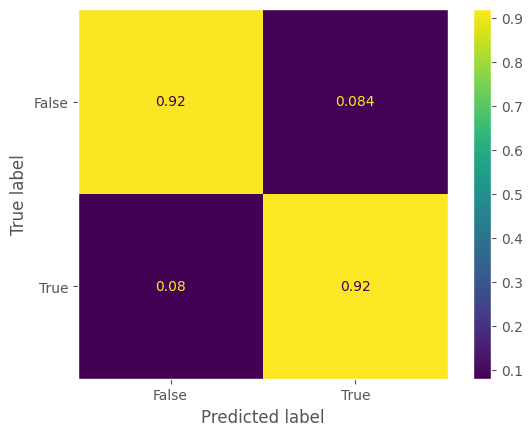

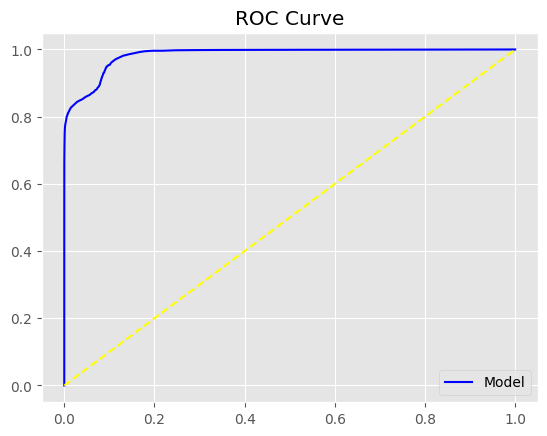

Accuracy 0.92
Precision: 0.04
Recall: 0.92
F1 Score 0.08
AUC: 0.9842172996911116


In [95]:
#test metrics
evaluate_model(y_val, y_pred_val, y_score_val, normalize_matrix="true")

In [96]:
#k-nearest neighbors

knn.fit(X_train, y_train)

y_pred_train = knn.predict(X_train)
y_score_train = knn.predict_proba(X_train)[:,1]

y_pred_val = knn.predict(X_val)
y_score_val = knn.predict_proba(X_val)[:,1]

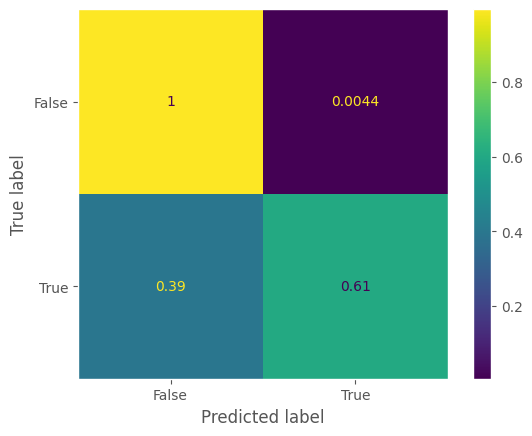

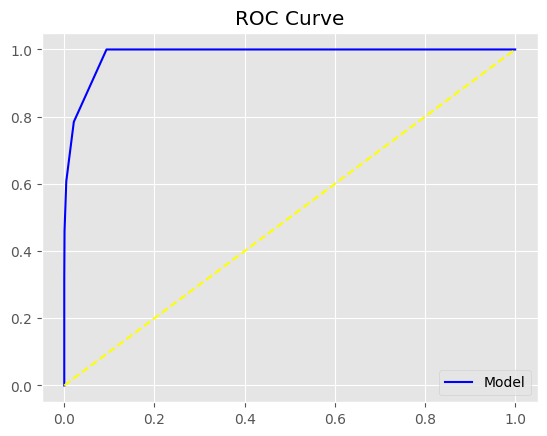

Accuracy 0.96
Precision: 0.93
Recall: 0.61
F1 Score 0.74
AUC: 0.9849443137430218


In [97]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train, normalize_matrix="true")

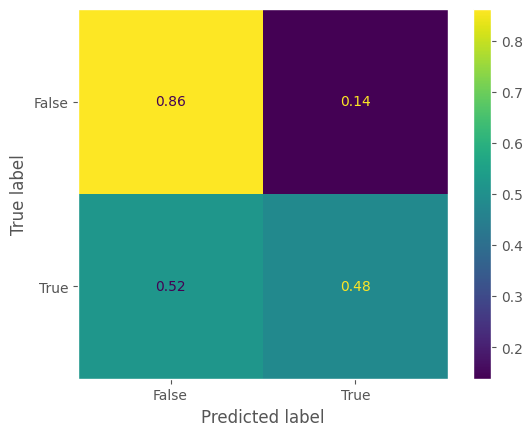

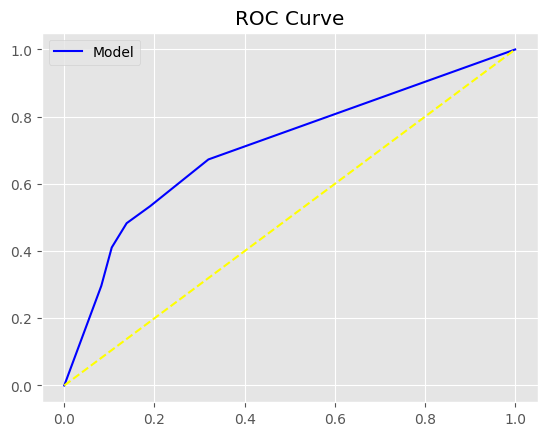

Accuracy 0.86
Precision: 0.01
Recall: 0.48
F1 Score 0.03
AUC: 0.7085689467963563


In [98]:
#test metrics
evaluate_model(y_val, y_pred_val, y_score_val, normalize_matrix="true")

In [99]:
#gradient boosting

gboost.fit(X_train, y_train)

y_pred_train = gboost.predict(X_train)
y_score_train = gboost.predict_proba(X_train)[:,1]

y_pred_val = gboost.predict(X_val)
y_score_val = gboost.predict_proba(X_val)[:,1]

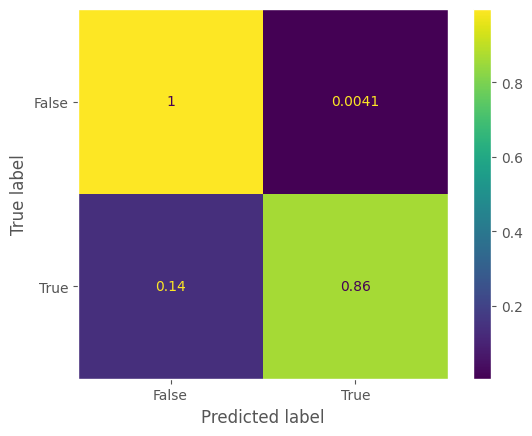

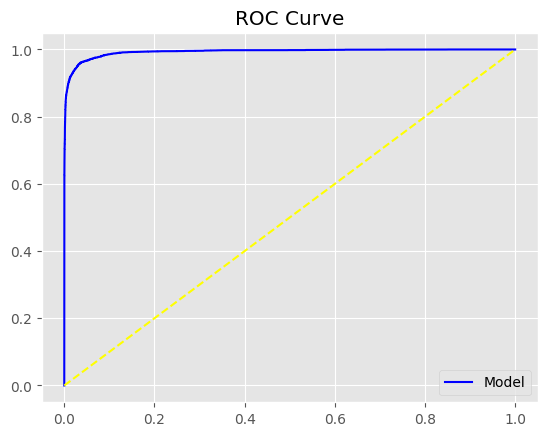

Accuracy 0.98
Precision: 0.95
Recall: 0.86
F1 Score 0.91
AUC: 0.9931141810133823


In [100]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train, normalize_matrix="true")

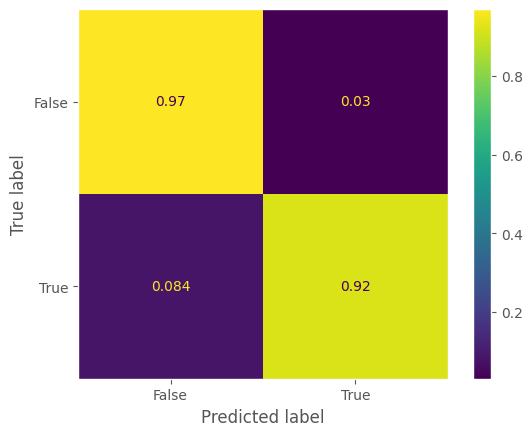

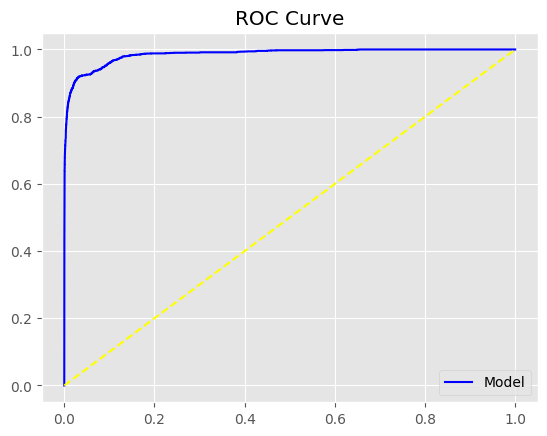

Accuracy 0.97
Precision: 0.11
Recall: 0.92
F1 Score 0.19
AUC: 0.986311128659577


In [101]:
#test metrics
evaluate_model(y_val, y_pred_val, y_score_val, normalize_matrix="true")

In [102]:
#LightGBM

lgbm.fit(X_train, y_train)

y_pred_train = lgbm.predict(X_train)
y_score_train = lgbm.predict_proba(X_train)[:,1]

y_pred_val = lgbm.predict(X_val)
y_score_val = lgbm.predict_proba(X_val)[:,1]

[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535


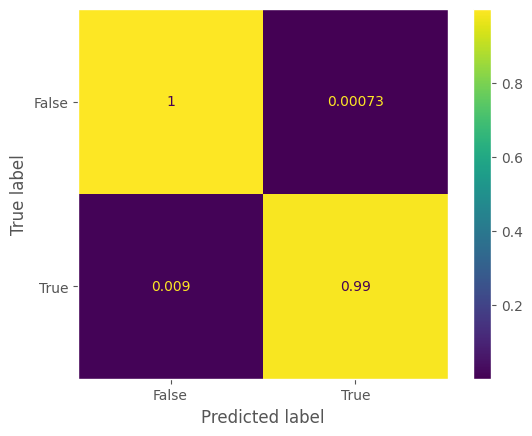

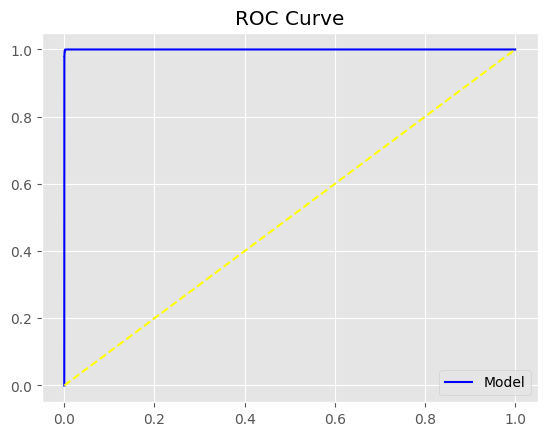

Accuracy 1.0
Precision: 0.99
Recall: 0.99
F1 Score 0.99
AUC: 0.9999822398349714


In [103]:
#training metrics
evaluate_model(y_train, y_pred_train, y_score_train, normalize_matrix="true")

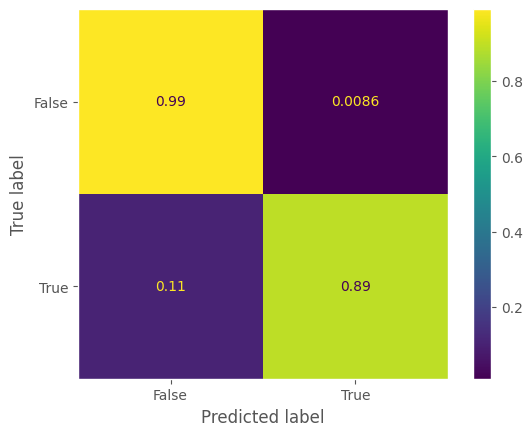

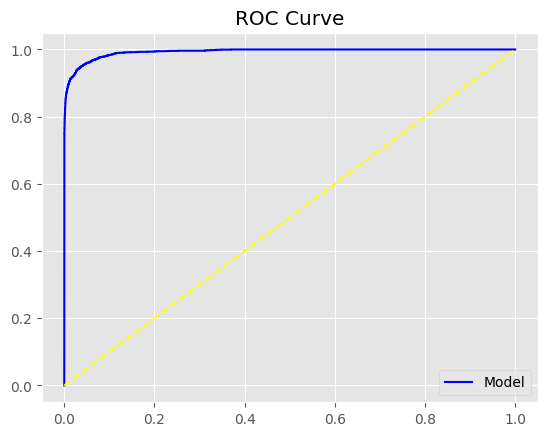

Accuracy 0.99
Precision: 0.29
Recall: 0.89
F1 Score 0.43
AUC: 0.9932288751855783


In [104]:
#test metrics
evaluate_model(y_val, y_pred_val, y_score_val, normalize_matrix="true")

# Hyperparameter Tuning

In [105]:
def tune_lgbm(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]

    print(params)

    mdl = LGBMClassifier(learning_rate= learning_rate,
                         num_leaves= num_leaves,
                         min_child_samples= min_child_samples,
                         subsample= subsample,
                         colsample_bytree= colsample_bytree,
                         random_state=23, subsample_freq=1,
                         n_estimators=200)

    mdl.fit(X_train, y_train)

    y_pred = mdl.predict(X_test)

    return -metrics.f1_score(y_test, y_pred)

In [106]:
space = [(1e-3, 1e-1, "log-uniform"), #learning_rate
        (2,128), #num_leaves
        (1,100), #min_child_samples
        (0.05, 1.0), #subsample
        (0.1, 1.0)] #colsample_bytree

In [107]:
%%capture
results = gp_minimize(tune_lgbm, space, random_state=23,
                      n_calls=100, n_random_starts=20, verbose= False)

In [108]:
params = results.x
params

[0.029002337536451678, 101, 1, 0.8641360341073422, 0.9337025027584772]

In [109]:
learning_rate = params[0]
num_leaves = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]

In [110]:
# LightGBM

lgbm = LGBMClassifier(learning_rate= learning_rate,
                      num_leaves= num_leaves,
                      min_child_samples= min_child_samples,
                      subsample= subsample,
                      colsample_bytree= colsample_bytree,
                      random_state=23, subsample_freq=1,
                      n_estimators=200)

lgbm.fit(X_train, y_train)

y_pred_train = lgbm.predict(X_train)
y_score_train = lgbm.predict_proba(X_train)[:,1]

y_pred_val = lgbm.predict(X_val)
y_score_val = lgbm.predict_proba(X_val)[:,1]

[LightGBM] [Info] Number of positive: 6005, number of negative: 60047
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 66052, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090913 -> initscore=-2.302535
[LightGBM] [Info] Start training from score -2.302535


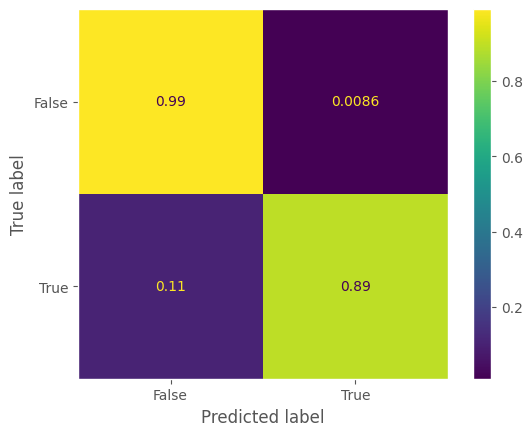

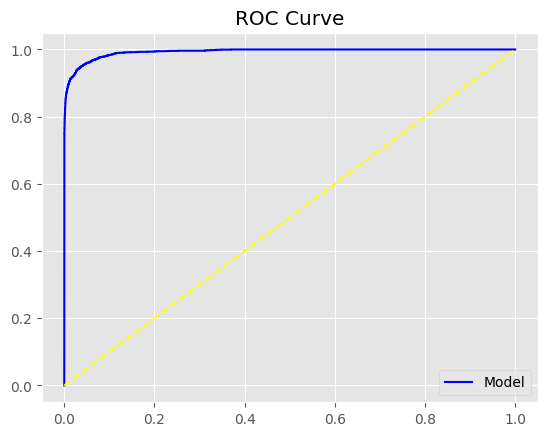

Accuracy 0.99
Precision: 0.29
Recall: 0.89
F1 Score 0.43
AUC: 0.9932288751855783


In [111]:
evaluate_model(y_val, y_pred_val, y_score_val, normalize_matrix="true")

#Conclusion

Since our event is related to fraud transactions, we've assumed the worst cenarios was getting high false negatives (transactions that we identify as non-frauds and ended up being fraudulents). Hence, we used an aproach to consider the recall metric being the most important for the model. We was able to get a recall of 90%. That means that we predict correctly 90% of all fraud transactions on test data.

Also, the precision of the model is very sensitive, because of the target imbalance. As you can see, only 1,1% or normal transactions were false positives, and it dropped the precision to 24%. That is because a small percentage of normal transactions if predicted wrong, means a high number of events compared to the fraud events in dataset.

The best approach to this problem would be having a way to calculate the mean cost of each false positive and false negative. This way, we could approach this tradeoff with better understanding of how much false positives and false negatives costs for the company.

